In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from config import PROJECTS_FILE, FILTERED_FILE, JUPYTER_FILE
#reads projects from Excel file
df = pd.read_excel(PROJECTS_FILE, keep_default_na=False)
print('Total repositories: ',len(df))

Total repositories:  130159


In [4]:
#Languages
nolanguages = df[df.languages==0]
df.drop(df[df['languages'] == 0].index, inplace = True)
print('Total repositories after filtering repositories with "empty languages":',len(df))

Total repositories after filtering repositories with "empty languages": 130159


In [5]:
#Filters repositories wich name contains "courses", because these repositories do not belong to our scopus.
#This repositories are saved in a new file, and then deleted from the original dataframe
courses = df.loc[df.name.str.contains('course',case=False)]
df.drop(df.loc[df.name.str.contains('course',case=False)].index, inplace=True )
print('Total repositories after filtering "courses":',len(df))

Total repositories after filtering "courses": 130159


In [6]:
cours = df.loc[df.name.str.contains('cours',case=False)]
df.drop(df.loc[df.name.str.contains('cours',case=False)].index, inplace=True )
print('Total repositories after filtering "cours":',len(df))

Total repositories after filtering "cours": 130159


In [7]:
curso = df.loc[df.name.str.contains('curso',case=False)]
df.drop(df.loc[df.name.str.contains('curso',case=False)].index, inplace=True )
print('Total repositories after filtering "curso":',len(df))

Total repositories after filtering "curso": 130159


In [8]:
cursos = df.loc[df.name.str.contains('cursos',case=False)]
df.drop(df.loc[df.name.str.contains('cursos',case=False)].index, inplace=True )
print('Total repositories after filtering "cursos":',len(df))

Total repositories after filtering "cursos": 130159


In [9]:
emptycommits = df.loc[df['commits'] == '']
df.drop(df[df['commits'] == ''].index, inplace = True)
print('Total repositories after filtering repositories with "empty commits":',len(df))


Total repositories after filtering repositories with "empty commits": 130159


In [10]:
nocontributors = df[df.contributors == 0]
df.drop(df[df['contributors'] == 0].index, inplace = True)
print('Total repositories after filtering repositories with "empty contributors":',len(df))


Total repositories after filtering repositories with "empty contributors": 130159


In [11]:
print(df['diskUsage'].sum())

2113687900


In [12]:
#Counting how many repositories have each stargazer 
df.stargazers.value_counts(dropna=False).rename_axis('Stargazers').to_frame('Counts')

#data = df.stargazers.value_counts(dropna=False).rename_axis('Stargazers').to_frame('Counts')
#print (data)

,Counts
Stargazers,
0,111184
1,11423
2,2629
3,1154
4,651
...,...
335,1
336,1
337,1


In [13]:
#Counting how many contributors the repositories have 
df.contributors.value_counts(dropna=False).rename_axis('Contributors').to_frame('Counts')


,Counts
Contributors,
1,113357
2,6767
3,2561
4,1728
5,738
...,...
104,1
70,1
60,1


In [14]:
#Counting how many commits the repositories have 
df.commits.value_counts(dropna=False).rename_axis('Commits').to_frame('Counts')


,Counts
Commits,
2,17273
3,12815
1,10459
4,9798
5,8081
...,...
887,1
486,1
601,1


In [15]:
#Counting how many languages the repositories have 
df.languages.value_counts(dropna=False).rename_axis('Languages').to_frame('Counts')


,Counts
Languages,
1,89241
2,24823
3,8367
4,3779
5,1809
6,837
7,404
8,232
10,219


In [16]:
#Counting how many issues the repositories have 
df.issues.value_counts(dropna=False).rename_axis('Issues').to_frame('Counts')


,Counts
Issues,
0,126861
1,1477
2,412
3,259
4,189
...,...
179,1
482,1
244,1


In [17]:
#Counting how many branches the repositories have 
df.branches.value_counts(dropna=False).rename_axis('Branches').to_frame('Counts')

,Counts
Branches,
1,114624
2,9482
3,2452
4,1063
5,636
6,577
7,291
8,175
9,130


In [18]:
#Counting how many diskUsage the repositories have 
df.diskUsage.value_counts(dropna=False).rename_axis('DiskUsage').to_frame('Counts')


,Counts
DiskUsage,
1,2239
2,2007
3,1786
0,1588
4,1555
...,...
45822,1
90764,1
8866,1


<AxesSubplot: ylabel='Frequency'>

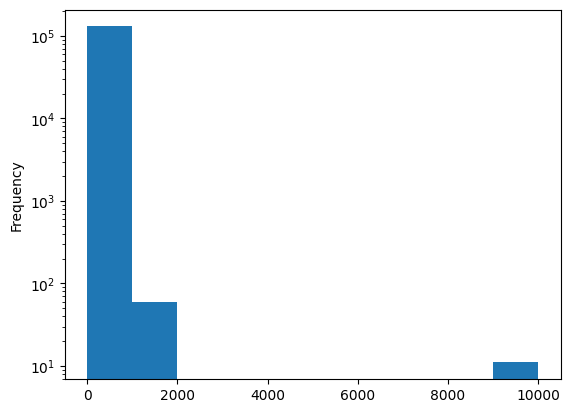

In [19]:
df["contributors"].plot(kind="hist", logy=True)

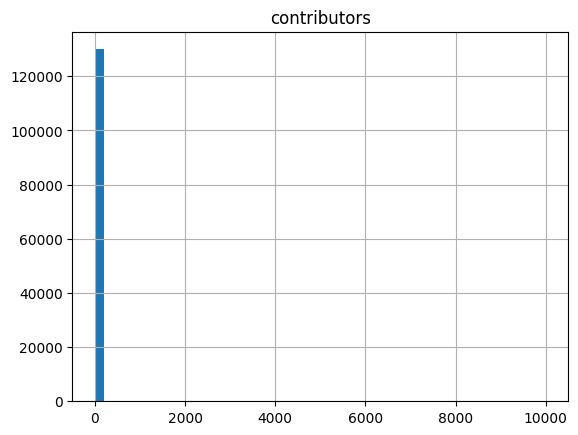

In [20]:
hist = df.hist(column=['contributors'], bins=50)

In [21]:
#Stargazers
df2=df[df.stargazers >0]
len(df2)

18975

In [22]:
#Contributors
df2 = df[df.contributors >= 2]
len(df2)

16802

In [23]:
df2 = df[df.contributors == 0]
df2
df2.to_csv('nocontributors.csv',index=True)

<AxesSubplot: ylabel='Frequency'>

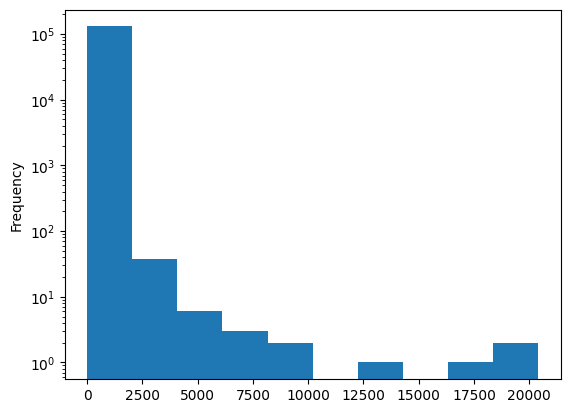

In [24]:
df["commits"].plot(kind="hist", logy=True)

In [25]:
#Commits
df2 = df[df.commits == 0]
len(df2)

0

In [26]:
df2 = df[df.commits >= 1]
len(df2)

130159

In [27]:
#Languages
df2 = df[df.languages==0]
len(df2)

0

In [28]:
df2 = df[df.languages > 1]
len(df2)

40918

In [29]:
df.primaryLanguage.value_counts()

Jupyter Notebook    82628
Python              18746
HTML                11243
R                   10826
JavaScript           1245
                    ...  
D                       1
LookML                  1
Tcl                     1
Stylus                  1
NSIS                    1
Name: primaryLanguage, Length: 130, dtype: int64

In [30]:
len(df.primaryLanguage.value_counts())

130

In [31]:
#filters repositories by language, keeping just the ones that use the top 10 languages in the corpus 
df2 = df.groupby('primaryLanguage').filter(lambda x: len(x) >= 18)
len(df2)

129775

In [32]:
pd.set_option('display.max_colwidth', -1) 
df

/tmp/ipykernel_3586/3613700250.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,owner,name,createdAt,pushedAt,isMirror,diskUsage,primaryLanguage,languages,contributors,watchers,stargazers,forks,issues,commits,pullRequests,branches,tags,releases,description
0,jakevdp,PythonDataScienceHandbook,2016-08-10 14:24:36,2021-11-12 19:40:00,0,34707,Jupyter Notebook,5,16,1738,31692,14160,145,234,164,6,0,0,Python Data Science Handbook: full text in Jupyter Notebooks
1,donnemartin,data-science-ipython-notebooks,2015-01-23 19:38:29,2021-11-04 20:19:10,0,49025,Python,4,12,1627,21825,6809,31,543,53,2,0,0,"Data science Python notebooks: Deep learning (TensorFlow, Theano, Caffe, Keras), scikit-learn, Kaggle, big data (Spark, Hadoop MapReduce, HDFS), matplotlib, pandas, NumPy, SciPy, Python essentials, AWS, and various command lines."
2,virgili0,Virgilio,2019-03-12 18:45:36,2021-10-19 06:22:27,0,35112,Jupyter Notebook,6,31,785,13189,2509,37,1363,123,12,0,0,Your new Mentor for Data Science E-Learning.
3,ricklamers,gridstudio,2019-07-23 13:56:41,2020-10-02 07:15:50,0,130620,JavaScript,9,10,329,8702,1500,128,202,16,5,0,0,Grid studio is a web-based application for data science with full integration of open source data science frameworks and languages.
4,goplus,gop,2015-12-12 01:21:39,2021-11-19 14:24:55,0,22158,Go,3,28,198,7706,497,393,1906,517,7,92,91,"GoPlus - The Go+ language for engineering, STEM education, and data science"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130154,DefinitelyMaybe,Kaggle,2018-04-01 23:21:34,2018-06-06 09:38:08,0,14698,Python,1,1,1,0,0,0,7,0,1,0,0,Early Days in the Data Science field
130155,viditmathur,Data-Science-and-ML,2018-06-06 10:07:38,2018-06-06 10:11:33,0,3806,Jupyter Notebook,2,1,1,0,0,0,2,0,1,0,0,
130156,andridns,ml-snippets,2018-06-05 09:17:28,2018-06-06 11:06:44,0,19,Python,1,1,0,0,0,0,20,0,1,0,0,my implementations of functions found in ML / data science pipeline in numpy
130157,jinsk44,data-science-workbook,2018-05-28 13:16:52,2018-06-06 12:06:07,0,48271,Jupyter Notebook,1,1,1,0,0,0,6,0,1,0,0,


In [33]:
df.describe()

,isMirror,diskUsage,languages,contributors,watchers,stargazers,forks,issues,commits,pullRequests,branches,tags,releases
count,130159.000000,1.301590e+05,130159.000000,130159.000000,130159.000000,130159.000000,130159.000000,130159.000000,130159.000000,130159.000000,130159.000000,130159.000000,130159.000000
mean,0.000200,1.623928e+04,1.579599,6.454775,1.732450,2.654231,2.534907,0.287372,21.778778,0.762252,1.314131,0.088400,0.060234
std,0.014132,9.713855e+04,1.262176,99.192774,12.287543,133.291190,88.172313,11.068274,134.855118,16.306476,3.322937,11.236564,10.959437
min,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,9.500000e+01,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.052000e+03,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,7.210000e+03,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,17.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.352860e+07,49.000000,10000.000000,2944.000000,31692.000000,14160.000000,3051.000000,20399.000000,4059.000000,735.000000,3869.000000,3866.000000


In [34]:
#saves filtered projetcts to Excel
#removes timezone from dates, since Excel does not know how to handle that
df.createdAt = pd.to_datetime(df.createdAt).dt.tz_localize(None) 
df.pushedAt = pd.to_datetime(df.pushedAt).dt.tz_localize(None)
df.to_excel(FILTERED_FILE, index=False)

In [35]:
#df.primaryLanguage.value_counts()
df.primaryLanguage.value_counts(dropna=False).rename_axis('PrimaryLanguage').to_frame('Counts')

,Counts
PrimaryLanguage,
Jupyter Notebook,82628
Python,18746
HTML,11243
R,10826
JavaScript,1245
...,...
D,1
LookML,1
Tcl,1


<AxesSubplot: ylabel='primaryLanguage'>

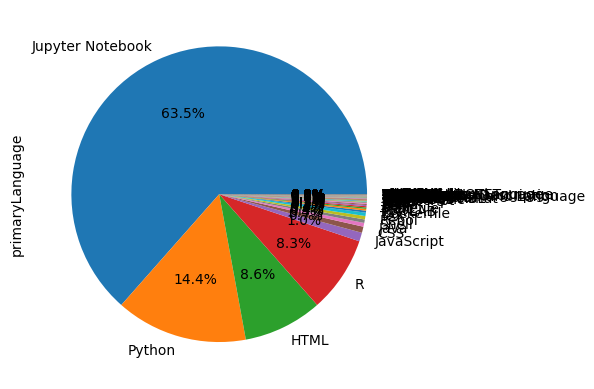

In [36]:
df.primaryLanguage.value_counts().plot(kind='pie', autopct='%1.1f%%')

<AxesSubplot: ylabel='stargazers'>

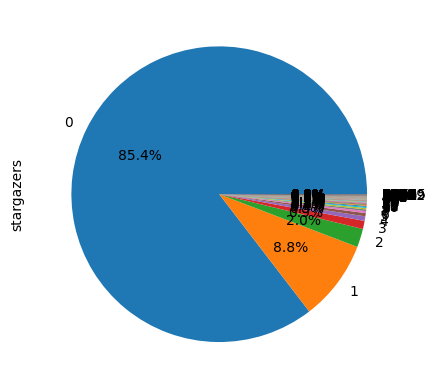

In [37]:
df.stargazers.value_counts().plot(kind='pie', autopct='%1.1f%%')

<AxesSubplot: ylabel='Frequency'>

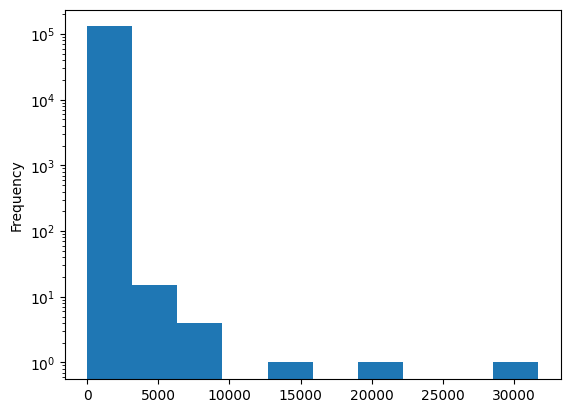

In [38]:
df["stargazers"].plot(kind="hist", logy=True)

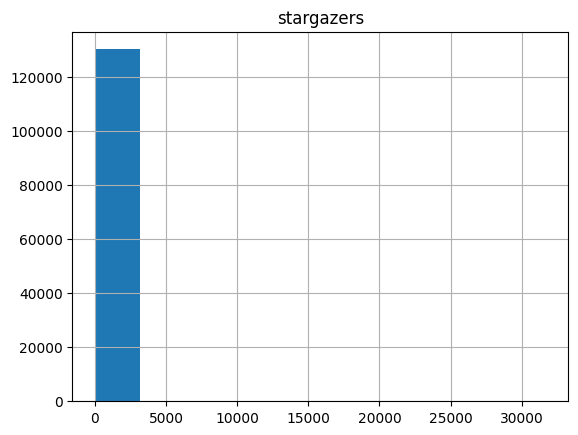

In [39]:
hist = df.hist(column=['stargazers'], bins=10)

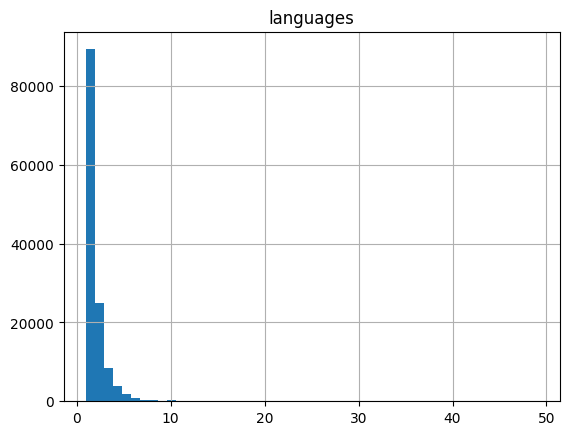

In [40]:
hist = df.hist(column=['languages'], bins=50)

<AxesSubplot: ylabel='Frequency'>

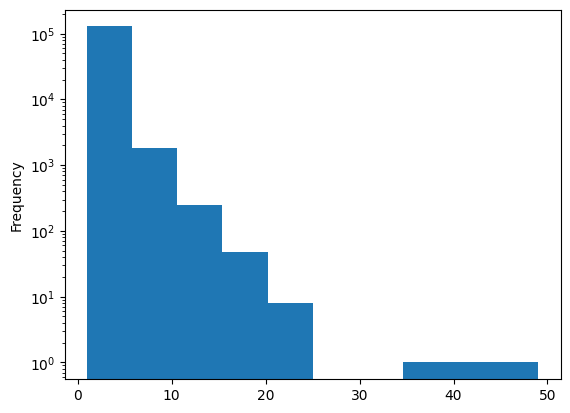

In [41]:
df["languages"].plot(kind="hist", logy=True)

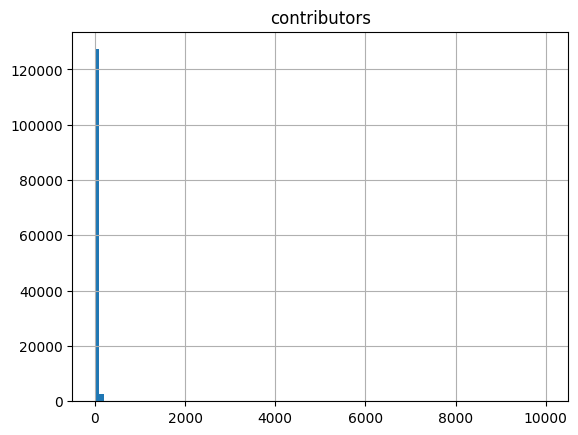

In [42]:
hist = df.hist(column=['contributors'], bins=100)

<AxesSubplot: ylabel='Frequency'>

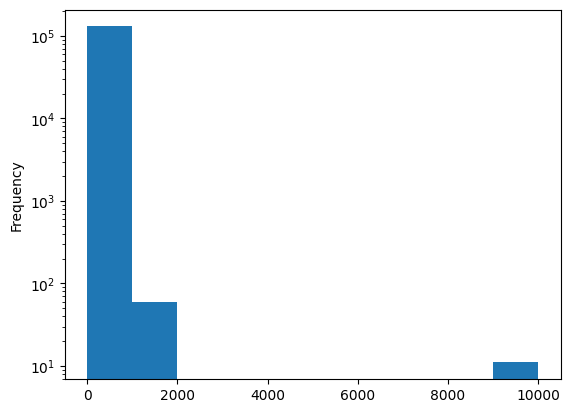

In [43]:
df["contributors"].plot(kind="hist", logy=True)

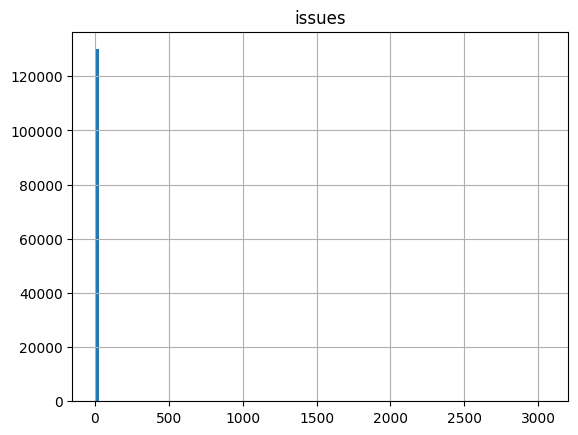

In [44]:
hist = df.hist(column=['issues'], bins=100)

<AxesSubplot: ylabel='Frequency'>

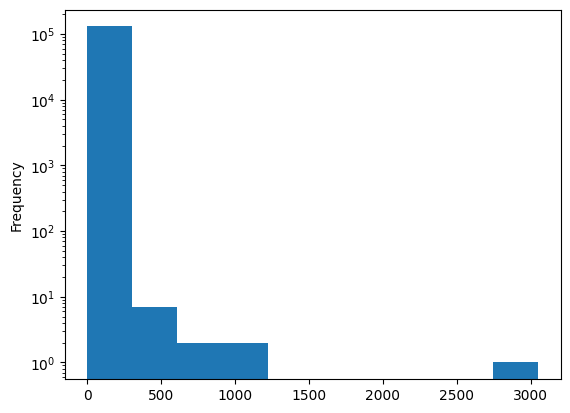

In [45]:
df["issues"].plot(kind="hist", logy=True)

<AxesSubplot: ylabel='Frequency'>

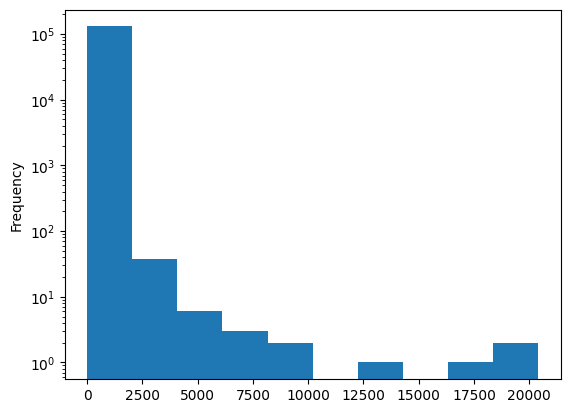

In [46]:
#hist = df.hist(column=['commits'], bins=100)
df["commits"].plot(kind="hist", logy=True)

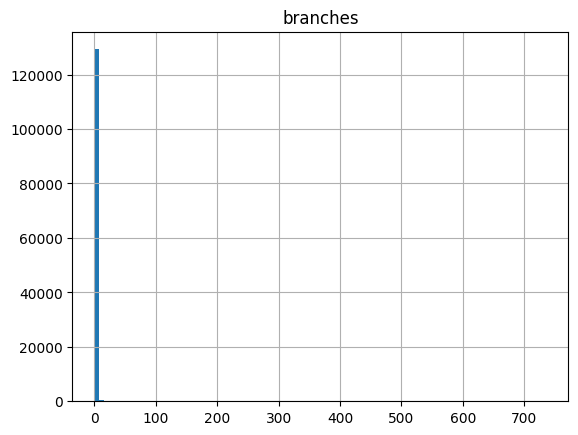

In [47]:
hist = df.hist(column=['branches'], bins=100)

<AxesSubplot: ylabel='Frequency'>

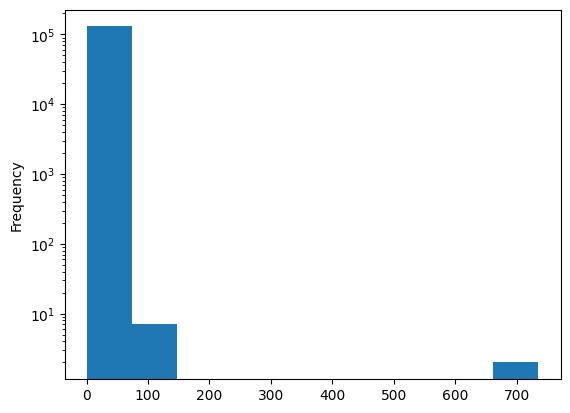

In [48]:
df["branches"].plot(kind="hist", logy=True)

Text(0.5, 0, 'KB')

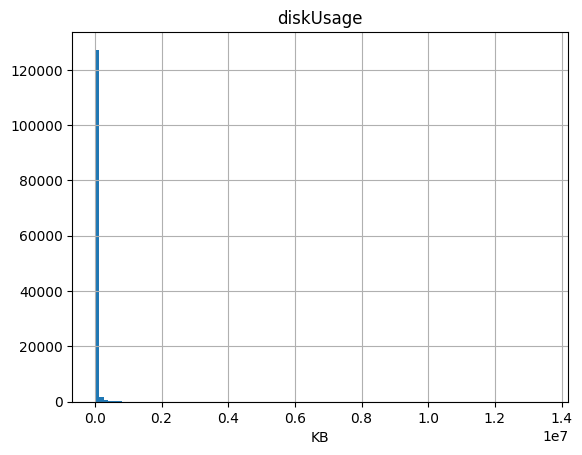

In [49]:
hist = df.hist(column=['diskUsage'], bins=100)
plt.xlabel("KB")

<AxesSubplot: ylabel='Frequency'>

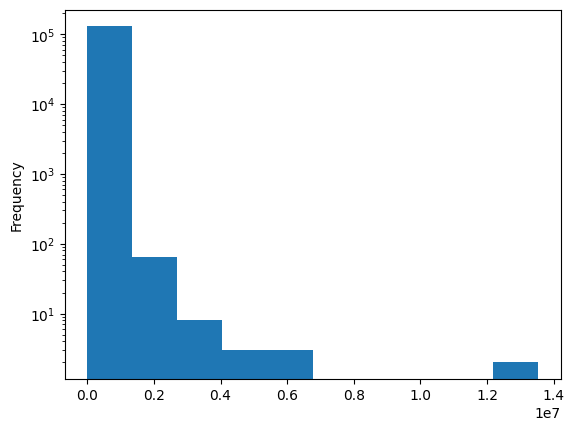

In [50]:
df["diskUsage"].plot(kind="hist", logy=True)

In [51]:
corr = df.drop('isMirror', axis=1).corr()
corr.style.background_gradient(cmap='Reds')

/tmp/ipykernel_3586/596018838.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop('isMirror', axis=1).corr()


,diskUsage,languages,contributors,watchers,stargazers,forks,issues,commits,pullRequests,branches,tags,releases
diskUsage,1.000000,0.214960,-0.002004,0.004857,0.008320,0.005158,0.025960,0.113480,0.035004,0.036118,0.004492,0.002042
languages,0.214960,1.000000,0.006435,0.021249,0.033606,0.017348,0.064066,0.177383,0.087605,0.108067,0.019584,0.013900
contributors,-0.002004,0.006435,1.000000,0.302733,0.030564,0.177716,0.022672,0.020250,0.018355,0.016992,0.008001,0.006495
watchers,0.004857,0.021249,0.302733,1.000000,0.636083,0.387917,0.104259,0.066106,0.099408,0.046286,0.016290,0.010012
stargazers,0.008320,0.033606,0.030564,0.636083,1.000000,0.533922,0.214544,0.109114,0.187498,0.084599,0.031848,0.014698
forks,0.005158,0.017348,0.177716,0.387917,0.533922,1.000000,0.069162,0.039100,0.073499,0.021891,0.004988,0.002336
issues,0.025960,0.064066,0.022672,0.104259,0.214544,0.069162,1.000000,0.513216,0.811903,0.546137,0.186964,0.068577
commits,0.113480,0.177383,0.020250,0.066106,0.109114,0.039100,0.513216,1.000000,0.503092,0.343274,0.148370,0.068639
pullRequests,0.035004,0.087605,0.018355,0.099408,0.187498,0.073499,0.811903,0.503092,1.000000,0.642653,0.283453,0.176092
branches,0.036118,0.108067,0.016992,0.046286,0.084599,0.021891,0.546137,0.343274,0.642653,1.000000,0.182496,0.093179


In [52]:
df2 = df.query("primaryLanguage== 'Jupyter Notebook'")
df2[:10].to_excel(JUPYTER_FILE, index=False)